<a href="https://colab.research.google.com/github/DanGlado/HSE-ML-HACK/blob/main/ML_optuna_bin_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost
!pip install joblib
!pip install catboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.filterwarnings('ignore')

import joblib

from tqdm._tqdm_notebook import tqdm_notebook

import optuna
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, log_loss, roc_curve
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

# Download

In [ ]:
df_full = pd.read_parquet('/content/drive/MyDrive/HSE_ML_Hack/data/train_prep_FINAL.parquet')

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7560 entries, 0002cf30347684df542e1a931f356875 to fffedf876a0ea3d39e54b706165a4826
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   neg_amount_count          7560 non-null   int64  
 1   pos_amount_count          7560 non-null   int64  
 2   pos_amount_sum            7560 non-null   float64
 3   neg_amount_sum            7560 non-null   float64
 4   amount_mean               7560 non-null   float64
 5   amount_std                7554 non-null   float64
 6   amount_max                7560 non-null   float64
 7   amount_min                7560 non-null   float64
 8   amount_median             7560 non-null   float64
 9   minutes_mean              7560 non-null   float64
 10  seconds_mean              7560 non-null   float64
 11  weighted_mcc              7560 non-null   float64
 12  tr_count                  7560 non-null   int64  
 13  tr_weeken

In [ ]:
df_nums = df_full.drop(columns=['term_id_most_frequent', 'trans_city_most_frequent'])

# FUNSTIONS

In [ ]:
SEED = 42
N_SPLITS = 5
def roc_curve_auc(roc_auc, best_params, model, y_valid, X_valid):
    # Print the ROC-AUC and logloss on the validation set
    print(f'ROC-AUC on validation set: {roc_auc}')
    print(f'Best params on validation set: {best_params}')

    # Plot ROC-AUC curve
    fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(X_valid)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Function to split data into train and validation sets for each fold
def get_train_valid_sets(X, y, test_size=0.2, random_state=SEED):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_valid, y_train, y_valid

# Function to train the model and return ROC-AUC score and logloss
def train_model(X_train, X_valid, y_train, y_valid, model):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    logloss = log_loss(y_valid, y_pred_proba)
    return roc_auc, logloss

## LogisticRegression

In [ ]:
# Set the best hyperparameters for the final model
# Function to define objective for Optuna optimization
def objective(trial):
    global model
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', None]),
        "C": trial.suggest_float("C", 0.001, 10),
        'tol': trial.suggest_float("tol", 0.0001, 0.5),
        'l1_ratio': trial.suggest_float("l1_ratio", 0.0001, 0.9),
        'solver' : trial.suggest_categorical('solver' , ['saga']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
    }

    # Set hyperparameters for the model
    model.set_params(**params)

    # Perform cross-validation
    roc_auc_scores = []
    logloss_scores = []
    for train_index, valid_index in folds.split(X, y):
        X_train, X_valid, y_train, y_valid = get_train_valid_sets(X[train_index], y[train_index])
        roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)
        roc_auc_scores.append(roc_auc)
        logloss_scores.append(logloss)

    # Optimize based on the mean ROC-AUC score
    return np.mean(roc_auc_scores) - np.std(roc_auc_scores)

model =  LogisticRegression()

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# Split the dataset into features (X) and target variable (y)
X = df_nums.drop(columns=['gender'])
y = df_nums['gender']

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(X)

In [ ]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params

# Set the best hyperparameters for the final model
model.set_params(**best_params)

In [ ]:
# Train the final model on the entire dataset
X_train, X_valid, y_train, y_valid = get_train_valid_sets(X, y)
roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)

ROC-AUC on validation set: 0.6027700586652551
Best params on validation set: {'penalty': 'l2', 'C': 7.128139370296911, 'tol': 0.08796358953092902, 'l1_ratio': 0.11849176610029058, 'solver': 'saga', 'fit_intercept': True}


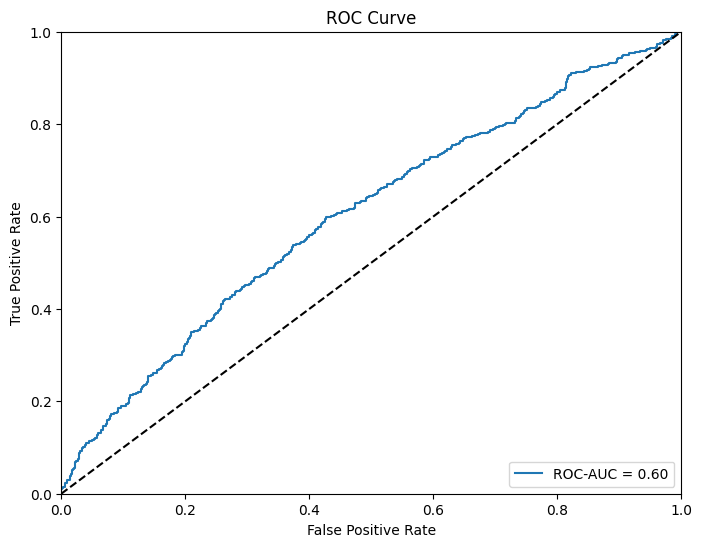

In [ ]:
roc_curve_auc(roc_auc, best_params, model, y_valid, X_valid)

# ExtraTree

In [ ]:
model = ExtraTreesClassifier()
# Set the best hyperparameters for the final model
# Function to define objective for Optuna optimization
def objective(trial):
    global model
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 15),
    }

    # Set hyperparameters for the model
    model.set_params(**params)

    # Perform cross-validation
    roc_auc_scores = []
    logloss_scores = []
    for train_index, valid_index in folds.split(X, y):
        X_train, X_valid, y_train, y_valid = get_train_valid_sets(X[train_index], y[train_index])
        roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)
        roc_auc_scores.append(roc_auc)
        logloss_scores.append(logloss)

    # Optimize based on the mean ROC-AUC score
    return np.mean(roc_auc_scores) - np.std(roc_auc_scores)

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# Split the dataset into features (X) and target variable (y)
X = df_nums.drop(columns=['gender'])
y = df_nums['gender']

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(X)

In [ ]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params

# Set the best hyperparameters for the final model
model.set_params(**best_params)

[I 2023-11-19 12:13:07,792] A new study created in memory with name: no-name-0ab5f0f6-a20a-4112-b58c-bd3581c19bf1
[I 2023-11-19 12:13:19,738] Trial 0 finished with value: 0.7601145328708853 and parameters: {'n_estimators': 858, 'max_depth': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7601145328708853.
[I 2023-11-19 12:13:29,648] Trial 1 finished with value: 0.7537140591045938 and parameters: {'n_estimators': 959, 'max_depth': 8, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.7601145328708853.
[I 2023-11-19 12:13:39,964] Trial 2 finished with value: 0.7815533999887039 and parameters: {'n_estimators': 630, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.7815533999887039.
[I 2023-11-19 12:13:43,936] Trial 3 finished with value: 0.7757042202905932 and parameters: {'n_estimators': 354, 'max_depth': 23, 'min_samples_leaf': 12}. Best is trial 2 with value: 0.7815533999887039.
[I 2023-11-19 12:13:55,292] Trial 4 finished with value: 0.79328832257313

ExtraTreesClassifier(max_depth=23, min_samples_leaf=3, n_estimators=364)

In [ ]:
# Train the final model on the entire dataset
X_train, X_valid, y_train, y_valid = get_train_valid_sets(X, y)
roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)

ROC-AUC on validation set: 0.7965153720612236
Best params on validation set: {'n_estimators': 364, 'max_depth': 23, 'min_samples_leaf': 3}


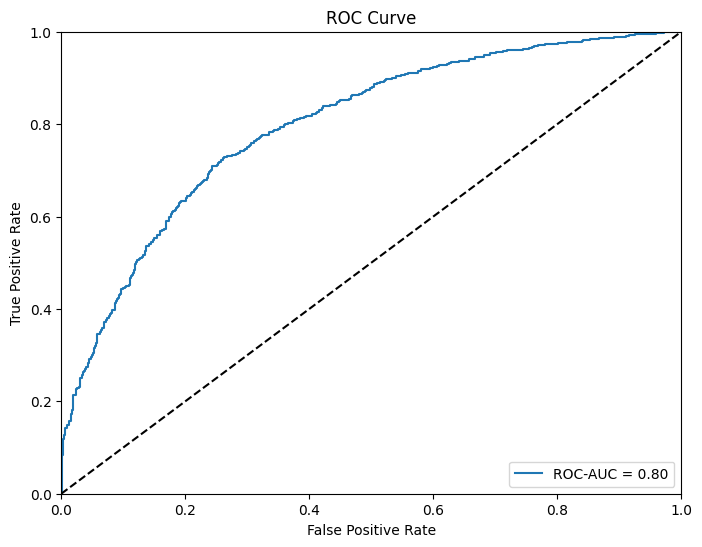

In [ ]:
roc_curve_auc(roc_auc, best_params, model, y_valid, X_valid)

# AdaBoost

In [ ]:
model = AdaBoostClassifier()
# Set the best hyperparameters for the final model
# Function to define objective for Optuna optimization
def objective(trial):
    global model
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1800),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.3)
    }

    # Set hyperparameters for the model
    model.set_params(**params)

    # Perform cross-validation
    roc_auc_scores = []
    logloss_scores = []
    for train_index, valid_index in folds.split(X, y):
        X_train, X_valid, y_train, y_valid = get_train_valid_sets(X[train_index], y[train_index])
        roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)
        roc_auc_scores.append(roc_auc)
        logloss_scores.append(logloss)

    # Optimize based on the mean ROC-AUC score
    return np.mean(roc_auc_scores) - np.std(roc_auc_scores)

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# Split the dataset into features (X) and target variable (y)
X = df_nums.drop(columns=['gender'])
y = df_nums['gender']

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(X)

In [ ]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params

# Set the best hyperparameters for the final model
model.set_params(**best_params)

[I 2023-11-19 12:30:02,744] A new study created in memory with name: no-name-a228bf9e-4883-4df4-878c-6f9bc0dddc06
[I 2023-11-19 12:31:31,598] Trial 0 finished with value: 0.7958778083550231 and parameters: {'n_estimators': 1129, 'algorithm': 'SAMME.R', 'learning_rate': 0.1035586928642402}. Best is trial 0 with value: 0.7958778083550231.
[I 2023-11-19 12:33:19,230] Trial 1 finished with value: 0.7943823587520147 and parameters: {'n_estimators': 1367, 'algorithm': 'SAMME.R', 'learning_rate': 0.14002992317618396}. Best is trial 0 with value: 0.7958778083550231.
[I 2023-11-19 12:34:16,742] Trial 2 finished with value: 0.7962395159555208 and parameters: {'n_estimators': 743, 'algorithm': 'SAMME.R', 'learning_rate': 0.1487534830059816}. Best is trial 2 with value: 0.7962395159555208.
[I 2023-11-19 12:36:14,315] Trial 3 finished with value: 0.7962866705944255 and parameters: {'n_estimators': 1463, 'algorithm': 'SAMME.R', 'learning_rate': 0.07421319042141122}. Best is trial 3 with value: 0.796

AdaBoostClassifier(learning_rate=0.029294240902587396, n_estimators=1597)

In [ ]:
# Train the final model on the entire dataset
X_train, X_valid, y_train, y_valid = get_train_valid_sets(X, y)
roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)

ROC-AUC on validation set: 0.7972934586035023
Best params on validation set: {'n_estimators': 1597, 'algorithm': 'SAMME.R', 'learning_rate': 0.029294240902587396}


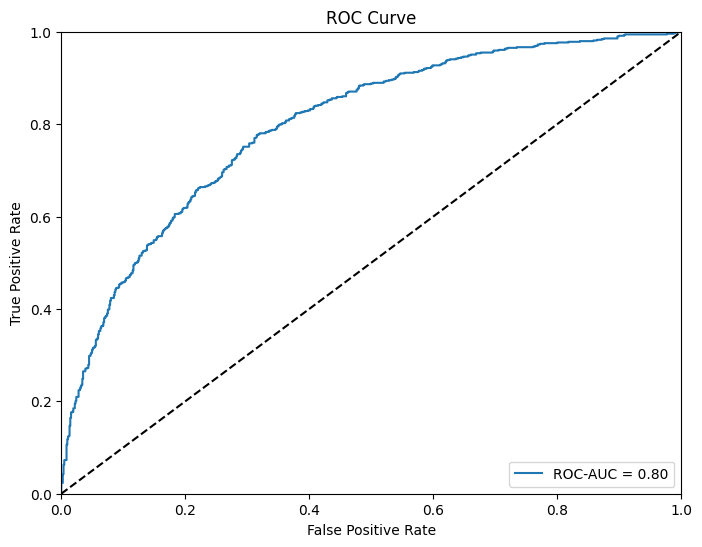

In [ ]:
roc_curve_auc(roc_auc, best_params, model, y_valid, X_valid)

## Testing new parquet

In [ ]:
df_test = pd.read_parquet('/content/drive/MyDrive/HSE_ML_Hack/data/train_prep_test.parquet').drop(columns=['term_id_most_frequent', 'trans_city_most_frequent', 'client_id'])

df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7560 entries, 0 to 7559
Columns: 165 entries, neg_amount_count to gender
dtypes: float64(156), int64(9)
memory usage: 9.6 MB


In [ ]:
folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# Split the dataset into features (X) and target variable (y)
X = df_test.drop(columns=['gender'])
y = df_test['gender']

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(X)

In [ ]:
model = AdaBoostClassifier()
# Set the best hyperparameters for the final model
# Function to define objective for Optuna optimization
def objective(trial):
    global model
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1800),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.3)
    }

    # Set hyperparameters for the model
    model.set_params(**params)

    # Perform cross-validation
    roc_auc_scores = []
    logloss_scores = []
    for train_index, valid_index in folds.split(X, y):
        X_train, X_valid, y_train, y_valid = get_train_valid_sets(X[train_index], y[train_index])
        roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)
        roc_auc_scores.append(roc_auc)
        logloss_scores.append(logloss)

    # Optimize based on the mean ROC-AUC score
    return np.mean(roc_auc_scores) - np.std(roc_auc_scores)

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
# Split the dataset into features (X) and target variable (y)
X = df_nums.drop(columns=['gender'])
y = df_nums['gender']

# Impute missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(X)

In [ ]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

# Set the best hyperparameters for the final model
model.set_params(**best_params)

[I 2023-11-19 13:41:44,270] A new study created in memory with name: no-name-54e06c91-da09-4e6a-8f80-cfd2dec34337
[I 2023-11-19 13:41:54,945] Trial 0 finished with value: 0.7960153777315958 and parameters: {'n_estimators': 148, 'algorithm': 'SAMME', 'learning_rate': 0.2589796562560356}. Best is trial 0 with value: 0.7960153777315958.
[I 2023-11-19 13:43:58,136] Trial 1 finished with value: 0.7914177361120401 and parameters: {'n_estimators': 1581, 'algorithm': 'SAMME.R', 'learning_rate': 0.2173732643637225}. Best is trial 0 with value: 0.7960153777315958.
[I 2023-11-19 13:45:04,163] Trial 2 finished with value: 0.7980139005000494 and parameters: {'n_estimators': 892, 'algorithm': 'SAMME', 'learning_rate': 0.280508027915754}. Best is trial 2 with value: 0.7980139005000494.
[I 2023-11-19 13:46:45,333] Trial 3 finished with value: 0.793869610078516 and parameters: {'n_estimators': 1283, 'algorithm': 'SAMME.R', 'learning_rate': 0.15593761567117456}. Best is trial 2 with value: 0.79801390050

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.280508027915754,
                   n_estimators=892)

In [ ]:
# Train the final model on the entire dataset
X_train, X_valid, y_train, y_valid = get_train_valid_sets(X, y)
roc_auc, logloss = train_model(X_train, X_valid, y_train, y_valid, model)

ROC-AUC on validation set: 0.7961113316571833
Best params on validation set: {'n_estimators': 892, 'algorithm': 'SAMME', 'learning_rate': 0.280508027915754}


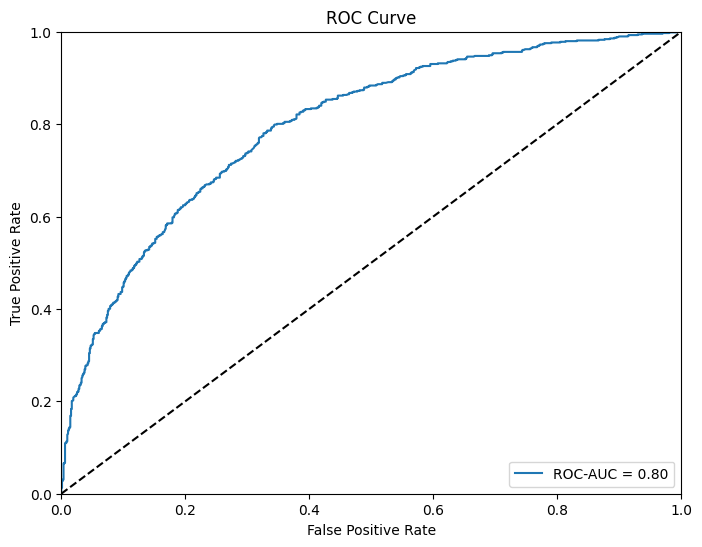

In [ ]:
roc_curve_auc(roc_auc, best_params, model, y_valid, X_valid)